# drosophila_simulation_cauterized

> Simulations with fixed boundary conditions on all sides, mimicking the cauterization experiments of Collinet 2015

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [ ]:
## import stuff

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.disorder as dis
import CE_simulation.hessian as hes
import CE_simulation.ecmc as ecm
import CE_simulation.phase_analysis as ana

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from scipy import ndimage, spatial

from collections import Counter, defaultdict
import itertools

from copy import deepcopy
import os
import sys
import pickle
import time as time_module

from joblib import Parallel, delayed

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)


In [ ]:
import importlib

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso); importlib.reload(drs);
importlib.reload(dis); importlib.reload(hes); importlib.reload(ecm); importlib.reload(ana);

In [ ]:
## analysis functions

def get_width_height(mesh, q=0.8, exclude=None):
    """Get tissue extension by means of q% x- and y-axis bounding box"""
    exclude = [] if exclude is None else exclude
    centroids = np.stack([v.get_centroid() for key, v in mesh.vertices.items()
                           if (not v.is_bdry()) and (not v._vid in exclude)])

    delta = np.quantile(centroids, axis=0, q=q)-np.quantile(centroids, axis=0, q=1-q,)
    return delta

In [ ]:
## set fixed simulation parameters

timeout_iteration = 20*60 

# initial condition parameters
n_x = 23
n_y = 34

w_passive = 7
w_passive_lr = 1.5

noise_gaussian = 0.1
noise_passive = 0.1
initial_strain = 0.2
initial_strain = np.sqrt(1+initial_strain)-1
isogonal = 0
orientation = "cable"

# triangulation dynamics parameters
m = 4
k = 25 # 6
k_cutoff = 0.3
k_relax = 2

# elastic energy parameters
mod_bulk = 1
mod_shear = 1
angle_penalty = 1000
bdry_penalty = 5000

# numerical parameters
dt = .005 # time step
forbid_reflip = 20
tri_mod_area = .01 # triangle area regularization
minimal_l = 0.06
tol, maxiter = (1e-4, 50000) # 100000
epsilon_l = (1e-3, 1e-3)  # mollifying parameters to ensure energy differentiability
bdr_weight = 4 # avoid problems at boundary

# elastic energy patterning
rel_bulk_modulus = 0.8 # reduction in bulk modulus in passive cells
rel_shear_modulus = 0.8 # reduction in shear modulus in passive cells
rel_angle_penalty = 0.995

def rhs_rest_shape(v): # no rest shape relaxation, since we have no passive cells
    return 0

# package all into a single dict to pass to the optimizer method
energy_args = {'mod_bulk': mod_bulk, 'mod_shear': mod_shear,
               'angle_penalty': angle_penalty, 'bdry_penalty': bdry_penalty, 'epsilon_l': epsilon_l,
               'mod_area': 0, 'mod_perimeter': 0}
optimizer_args = {'energy_args': energy_args, 'tol': tol, 'maxiter': maxiter, 'verbose': True,
                  'bdr_weight': bdr_weight}

### Definining initial cond geometry

In [ ]:
mesh_initial, property_dict = drs.create_rect_initial(n_x, n_y, noise=noise_gaussian, initial_strain=initial_strain,
                                                      orientation='orthogonal', isogonal=0, random_seed=2,
                                                      boundaries=['top', 'bottom', 'left', 'right'], w_passive=w_passive, w_passive_lr=w_passive_lr)

edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_colors = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5]) for key in mesh_initial.vertices.keys() if not key in property_dict['passive_cells']}

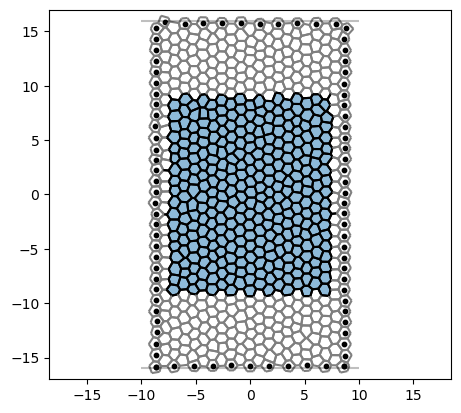

In [ ]:
mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
#mesh_initial.triplot()

bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
plt.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
for key in msh.flatten([x[1] for x in mesh_initial.bdry_list]):
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k", s=10)

plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])
plt.gca().set_aspect("equal", adjustable="box")

In [ ]:
# set passive tensions in passive region
for e in property_dict['passive_edges']:     
    mesh_initial.hes[e].passive = mesh_initial.hes[e].twin.passive = np.random.normal(loc=1, scale=noise_passive)

# patterning of triangulation dynamics
def params_pattern(fid):
    if fid in property_dict['passive_faces']:
        return {"m": None, "k_cutoff": None, "k": k, "is_active": False, "subtract_passive": False} 
    return {"m": m, "k_cutoff": k_cutoff, "k": k, "is_active": True, "subtract_passive": False}

# patterning of mechanics
cell_id_to_modulus = defaultdict(lambda: (lambda x: 1))
cell_id_to_modulus["mod_bulk"] = lambda x: 1-rel_bulk_modulus*(x in property_dict['passive_cells'])
cell_id_to_modulus["mod_shear"] = lambda x: 1-rel_shear_modulus*(x in property_dict['passive_cells'])
# also reduce the angle penalty proportionally in the passive region
edge_id_to_angle_penalty = lambda x: 1-rel_angle_penalty*(x in property_dict['passive_edges'])
optimizer_args['cell_id_to_modulus'] = cell_id_to_modulus
optimizer_args['edge_id_to_angle_penalty'] = edge_id_to_angle_penalty

## simulation with this given initial condition

In [ ]:
# initialize the simulation

times = [0]; last_flipped_edges = [[]]
mesh = mesh_initial
mesh_previous = deepcopy(mesh)
meshes = [mesh_previous]

In [ ]:
n_steps = 180

In [ ]:
# main simulation loop

for i in tqdm(range(len(meshes), n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass_new_passive_rest, params=params_pattern,
                    rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation.
    sol = mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4, return_sol=True, reset_intrinsic=False,
                                     soften_direct=0, soften_indirect=0)
    # cancel execution if this fails. precision loss and insufficient iteration errors are typically harmless.
    if sol["status"] !=0 and (sol["message"] == "NaN result encountered."):
        break
    # relax intrinsic lengths
    if k_relax < np.infty:
        mesh.euler_step_relax(k_relax=k_relax/dt, dt=dt)
    else:
        mesh.set_rest_lengths()
    # primal optimization
    sol = mesh.optimize_cell_shape(**optimizer_args, return_sol=True)
    if sol["status"] !=0 and (sol["message"] == "NaN result encountered."):
        break
    # check for intercalation
    flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                            minimal_l=minimal_l, reoptimize=False,
                                            optimizer_args=optimizer_args)
    # set passive tension on passive edges
    for e in flipped:
        if e in property_dict['passive_edges']:
            mesh.hes[e].passive = mesh.hes[e].twin.passive = np.random.normal(loc=1, scale=noise_passive)

    # rescale & reorient triangulation
    mesh.transform_vertices(dln.get_conformal_transform(mesh_previous, mesh))
    # log & save
    last_flipped_edges.append(flipped)
    times.append(times[-1]+dt)
    mesh_previous = deepcopy(mesh)
    meshes.append(mesh_previous)
# make measurements
last_flipped_edges.append([])

  0%|          | 0/67 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
len(meshes)

123

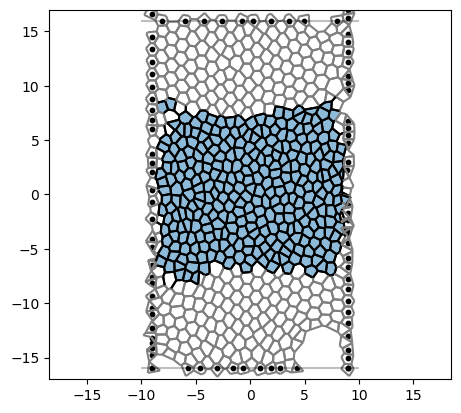

In [ ]:
t = 120

meshes[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
#mesh_initial.triplot()

plt.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
for key in msh.flatten([x[1] for x in mesh_initial.bdry_list]):
    plt.scatter(*meshes[t].vertices[key].get_centroid(), c="k", s=10)

plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])
plt.gca().set_aspect("equal", adjustable="box")

In [ ]:
## save the meshes

plot_dir = "/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/plots/SI_cauterized"
[m.save_mesh(f"{plot_dir}/meshes/mesh_{str(i).zfill(4)}") for i, m in enumerate(meshes)];
with open(f'{plot_dir}/meshes/last_flipped.pickle', 'wb') as handle:
    pickle.dump(last_flipped_edges, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Make plots - initial condition, final condition, time trace of the edge length during T1s

In [ ]:
edge_color = {key: "silver" for key in property_dict['passive_edges']}
cell_colors = {key: "#eebbaaff" for key in meshes[0].vertices.keys() if not key in property_dict['passive_cells']}

In [ ]:
active = [[351, 352, 353], [384, 385, 386], [419, 420, 421], [452, 453, 454]]
passive = [[342, 343, 344], [375, 376, 377], [410, 411, 412], [443, 444, 445]]
bdry_lst = list(msh.flatten([x[1] for x in mesh_initial.bdry_list]))

In [ ]:
120*dt*25

15.0

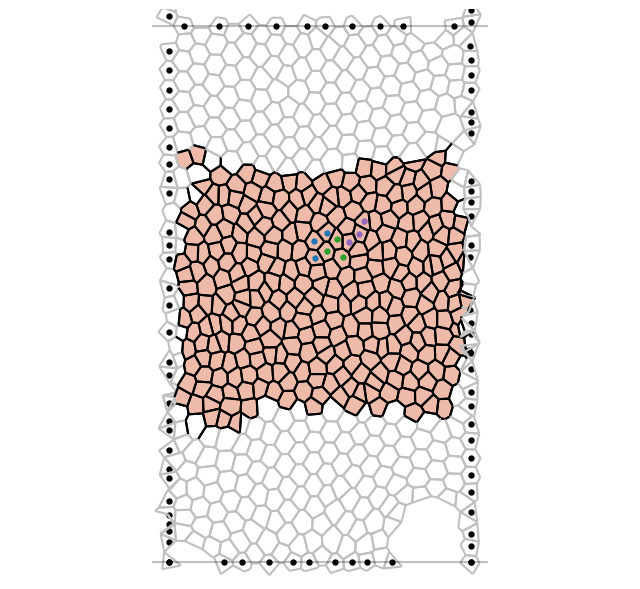

In [ ]:
fig = plt.figure(figsize=(8,8)) # 8,8

t = 120 #160 
s = 12.5

x = 1
for key in active[1]:
    plt.scatter(*meshes[t].vertices[key+x].get_centroid(), c="tab:blue", s=s, zorder=10)
for key in active[2]:
    plt.scatter(*meshes[t].vertices[key+x].get_centroid(), c="tab:green", s=s, zorder=10)
for key in active[3]:
    plt.scatter(*meshes[t].vertices[key+x].get_centroid(), c="tab:purple", s=s, zorder=10)

    
meshes[t].cellplot(edge_colors=edge_color, cell_colors=cell_colors)

# add line to visualize the slip boundary
if bdry_lst:
    plt.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        plt.scatter(*meshes[t].vertices[key].get_centroid(), c="k", s=s)


plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")

#plt.savefig(f"{plot_dir}/cauterized_15_mins.pdf")
#plt.savefig(f"{plot_dir}/cauterized_20_mins.pdf")

## length traces

In [ ]:
length_dicts = [x.get_primal_edge_lens(include_duplicates=True) for x in meshes]

In [ ]:
lengths_stacked = []

dt = 80
t0 = 40

max_t = len(meshes)
for i in range(t0, 100):
    for e in last_flipped_edges[i]:
        if not e in property_dict['passive_edges']:
            length = np.stack([x[e] for x in length_dicts])
            length_selected = length[max([0, i-dt]):min([max_t, i+dt])]
            pad_before = max([0, dt-i])
            pad_after = max([0, i+dt-max_t])
            length_selected = np.pad(length_selected, (pad_before, pad_after), mode="constant", constant_values=np.nan)
            lengths_stacked.append(length_selected)
            
lengths_stacked = np.stack(lengths_stacked)

In [ ]:
lengths_stacked.shape

(255, 160)

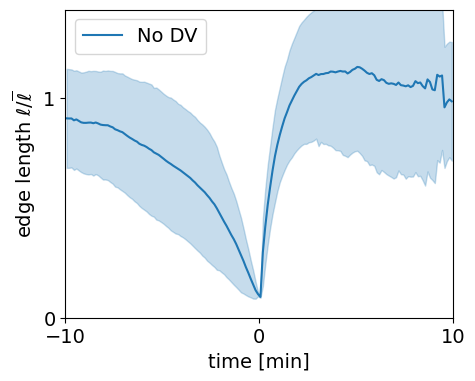

In [ ]:
fig = plt.figure(figsize=(5,4))

length_scale = np.mean([np.mean(list(x.values())) for x in length_dicts])

time_T1 = np.arange(lengths_stacked.shape[1]) * 0.005 * 25
time_T1 -= time_T1.mean()

mean = (np.nanmean(lengths_stacked, axis=0)) / length_scale
std = np.nanstd(lengths_stacked, axis=0) / length_scale

plt.plot(time_T1, mean, color='tab:blue', label='No DV')
plt.fill_between(time_T1, mean-std, mean+std, color='tab:blue', alpha=.25)

plt.xlim([-8, 8])
plt.xticks([-10, 0, 10], fontsize=14)
plt.yticks([0, 1], fontsize=14)
plt.ylim([0, 1.4])

plt.xlabel('time [min]', fontsize=14)
plt.ylabel(r'edge length $\ell/\overline{\ell}$', fontsize=14)
plt.legend(fontsize=14, loc="upper left")

plt.savefig(f"{plot_dir}/cauterized_junction_length.pdf")

In [ ]:
# not clear why the junctions increase in length so rapidly after a T1 ???

0.603775992426071